In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pickle
import os
from sklearn.preprocessing import MinMaxScaler
import time

In [29]:
str(int(time.time()))

'1565514386'

In [2]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.python.keras.initializers import RandomUniform
from tensorflow.python.keras.optimizers import RMSprop, ADAM
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

/Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 

In [5]:
FIGSIZE = (14,8)

In [3]:
df_breaks = pd.read_pickle('..//data//simulated_breaks_ix.pickle')
df_returns = pd.read_pickle('..//data//simulated_returns.pickle')
df_tangency_portfolio = pd.read_pickle('..//data//simulated_tangency_portfolios.pickle')
df_highest_sharp = pd.read_pickle('..//data//highest_shape_ratios.pickle')

### Identification of model

Since $\sum_{w_i \in W} w_i == 1 $ We can identify the model by predicting all the weights except the last one

In [7]:
#splitting data

# Cleaning and preprocessing

In [8]:
def max_val(x, max_val=5):
    """Function made for trimming weights of portfolio"""
    
    if abs(x) > max_val:
        return np.sign(x) * max_val
    return x

In [5]:
train_frac = 0.9
data_length = len(df_returns)
split_ix = int(train_frac * data_length)

# column removed for identification pruposes
skip_col = df_tangency_portfolio.columns[-1]
df_tangency = df_tangency_portfolio.drop(skip_col, axis=1)

# capping weird weigths
# df_tangency_masked = pd.DataFrame(df_tangency)
# for col in df_tangency_masked.columns:
#      df_tangency_masked[col] = df_tangency_masked[col].apply(max_val)

In [6]:
x_train = df_returns[0:split_ix]
x_test = df_returns[split_ix:]

In [7]:
y_train = df_highest_sharp[0:split_ix]
y_test = df_highest_sharp[split_ix:]

In [8]:
x_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
y_train_scaled = y_scaler.fit_transform(y_train)

In [9]:
x_test_scaled = x_scaler.transform(x_test)
y_test_scaled = y_scaler.transform(y_test)

In [10]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)


(1800000, 11)
(1800000, 11)


In [11]:
num_x_signals, num_y_signals = x_train_scaled.shape[1], y_train_scaled.shape[1]
print(num_x_signals, num_y_signals)

11 11


# Data generation

In [12]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(split_ix - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [13]:
batch_size = 256 # number of sequences
sequence_length = 250

In [14]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [15]:
x_batch, y_batch = next(generator)

In [16]:
x_batch.shape, y_batch.shape

((256, 250, 11), (256, 250, 11))

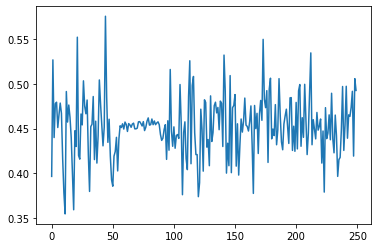

In [17]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

In [18]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# LSTM model

In [19]:
model = Sequential()
model.add(LSTM(units=256,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

init = RandomUniform(minval=-0.05, maxval=0.05)

model.add(Dense(num_y_signals,
                activation='softmax')

#model.add(Dense(num_y_signals, activation='sigmoid'))


W0811 11:02:34.964023 4400461248 deprecation.py:506] From /Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0811 11:02:35.276937 4400461248 deprecation.py:506] From /Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [20]:
optimizer = RMSprop(lr=1e-3)

In [21]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 256)         274432    
_________________________________________________________________
dense (Dense)                (None, None, 11)          2827      
Total params: 277,259
Trainable params: 277,259
Non-trainable params: 0
_________________________________________________________________


In [31]:
path_checkpoint = 'acfs.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [32]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [33]:
callback_tensorboard = TensorBoard(log_dir=f'./acfs_logs_{str(int(time.time()))}/',
                                   histogram_freq=0,
                                   write_graph=False)

In [34]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [35]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [36]:
%%time
model.fit_generator(generator=generator,
                    epochs=5,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

W0811 11:07:13.760027 4400461248 deprecation.py:323] From /Users/Jeppe/.local/share/virtualenvs/ACFS-LPq-wnhy/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5
 99/100 [============================>.] - ETA: 3s - loss: 2.3979
Epoch 00001: val_loss improved from inf to 2.39869, saving model to acfs.keras
100/100 [==============================] - 391s 4s/step - loss: 2.3979 - val_loss: 2.3987
Epoch 2/5
 99/100 [============================>.] - ETA: 3s - loss: 2.3981
Epoch 00002: val_loss did not improve from 2.39869

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 375s 4s/step - loss: 2.3980 - val_loss: 2.4002
Epoch 3/5
 99/100 [============================>.] - ETA: 3s - loss: 2.3975
Epoch 00003: val_loss did not improve from 2.39869

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 401s 4s/step - loss: 2.3975 - val_loss: 2.3994
Epoch 4/5
 99/100 [============================>.] - ETA: 2s - loss: 2.3968
Epoch 00004: val_loss did not improve from 2.39869
100/100 [==============================] - 333

In [37]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [38]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 52s 52s/sample - loss: 2.3987


In [39]:
print("loss (test-set):", result)

loss (test-set): 2.398693323135376


In [42]:
target_names = list(df_tangency_portfolio.columns[0:-1])
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = np.array(y_train)
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = np.array(y_test)
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        #p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

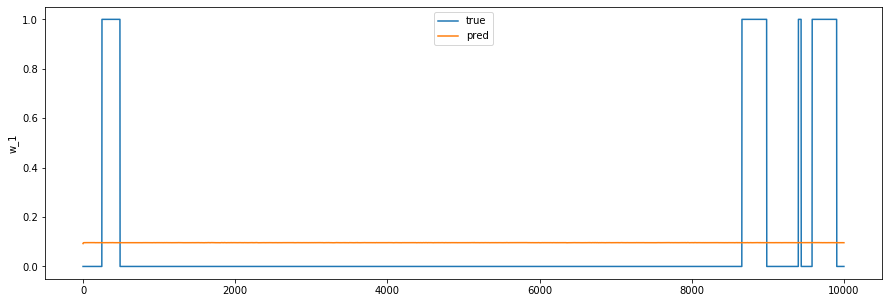

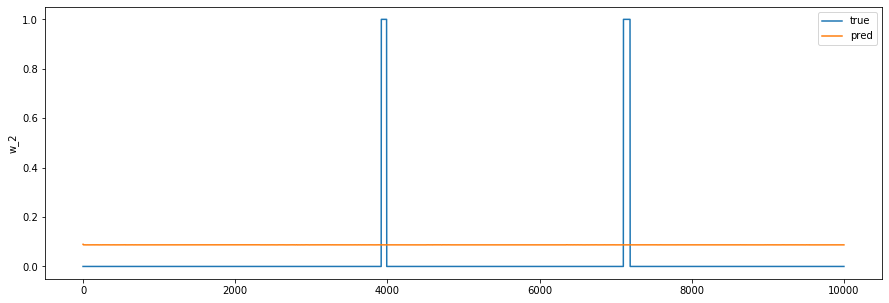

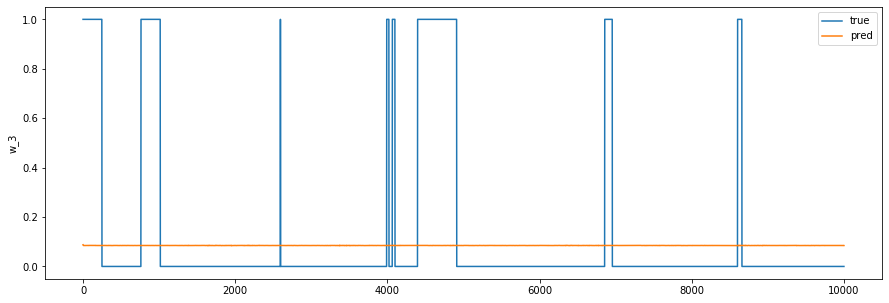

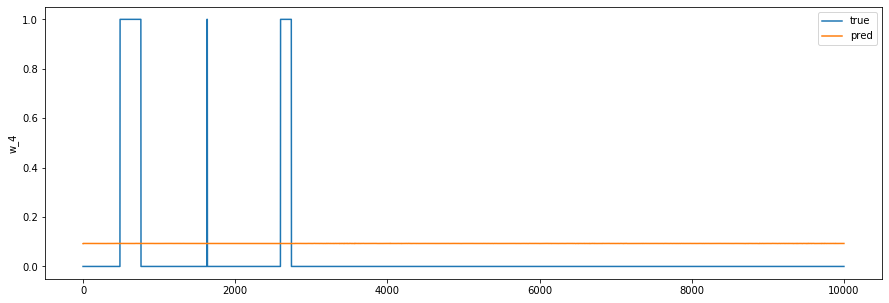

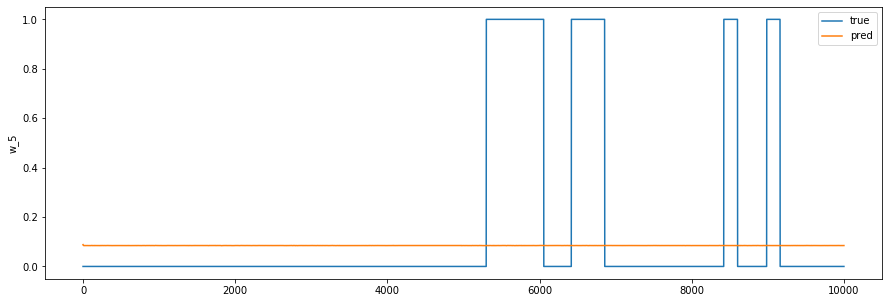

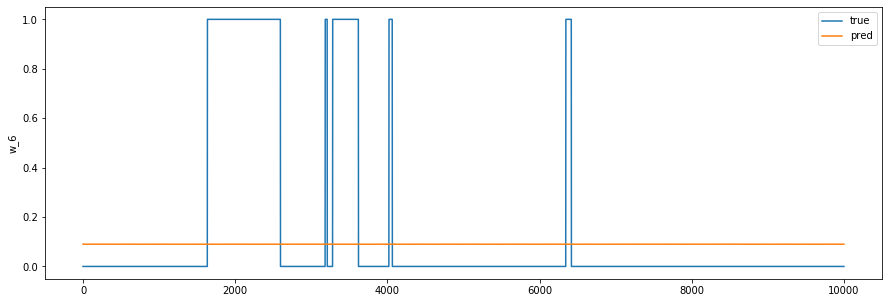

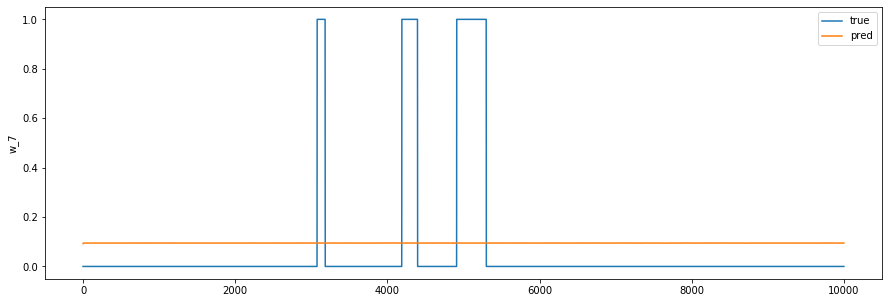

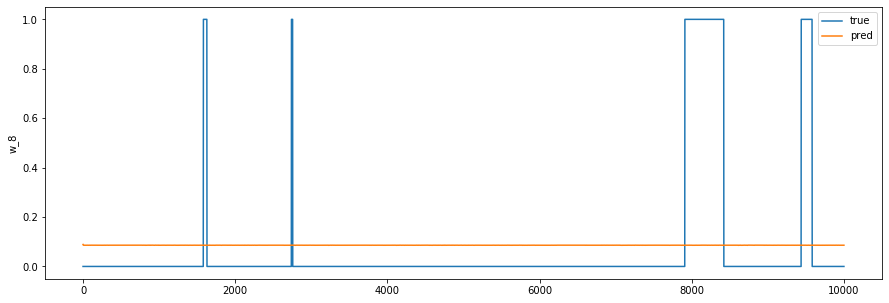

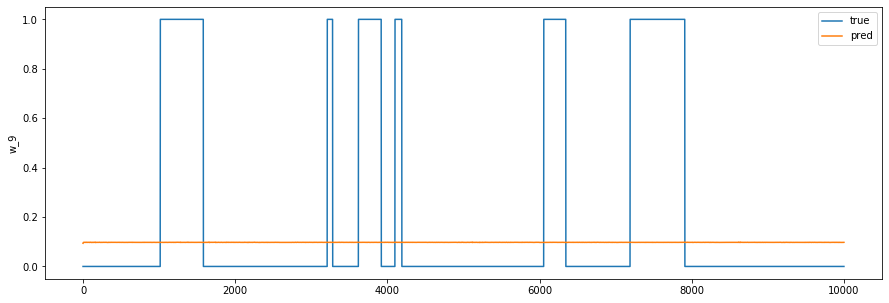

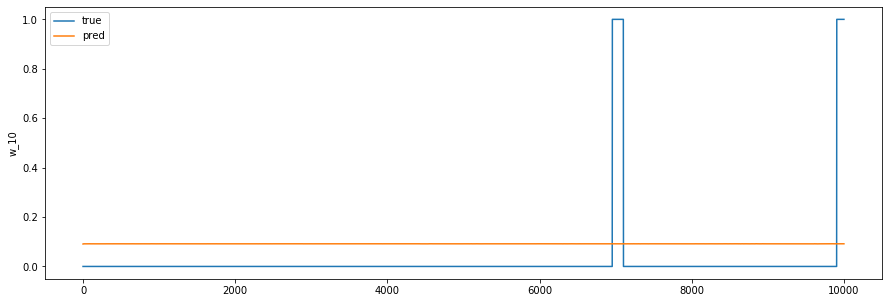

In [43]:
plot_comparison(start_idx=100, length=10000, train=True)

In [108]:
y_test['w_2']

1800000   -0.042883
1800001   -0.042883
1800002   -0.042883
1800003   -0.042883
1800004   -0.042883
             ...   
1999995    0.444745
1999996    0.444745
1999997    0.444745
1999998    0.444745
1999999    0.444745
Name: w_2, Length: 200000, dtype: float64

In [120]:
start_idx, length = 0, 1000
x = x_train_scaled
y_true = np.array(y_train)

end_idx = start_idx + length

# Select the sequences from the given start-index and
# of the given length.
x = x[start_idx:end_idx]
y_true = y_true[start_idx:end_idx]

# Input-signals for the model.
x = np.expand_dims(x, axis=0)

# Use the model to predict the output-signals.
y_pred = model.predict(x)

y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])


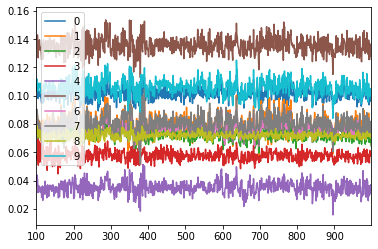

In [123]:
pd.DataFrame(y_pred_rescaled)[100:].plot()

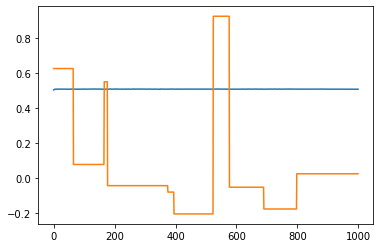

In [73]:
plt.plot(y_pred[0, :, 1])
plt.plot(df_tangency_masked['w_1'][0:1000])

In [77]:
y_resp = y_scaler.inverse_transform(y_pred[0])

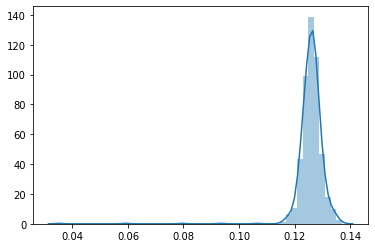

In [85]:
sbn.distplot(y_resp[:,0])

In [1]:
def calc_avg_loss(y_pred, y_true):
    (y_pred - y_true)
    

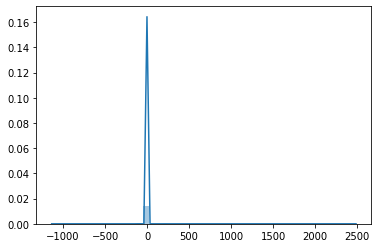

In [14]:
sbn.distplot(np.array(df_tangency_portfolio).flatten())

In [18]:
df = pd.DataFrame(df_tangency_portfolio)

for col in df.columns:
    df[col] = df[col].apply(max_val)

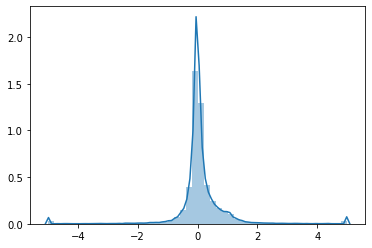

In [19]:
sbn.distplot()

(array([ 3455475., 12896497.,  5648028.]),
 array([-10. ,  -0.2,   0.2,  10. ]),
 <a list of 3 Patch objects>)

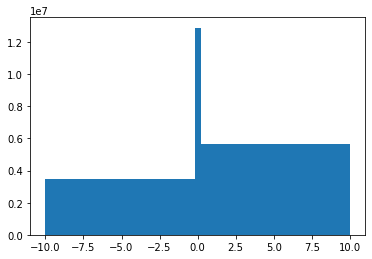

In [28]:
plt.hist(, bins=[-10, -0.2,0.2, 10])

In [23]:
np.mean(np.array(df_tangency_portfolio).flatten())

0.08994477649414724

In [31]:
k = np.array(df_tangency_portfolio).flatten()

In [33]:
from collections import defaultdict

In [62]:
def create_bins(bins):
    """bins: list of upper bounds for binning of count"""
    _bins = [(- np.inf, bins[0])]
    for ix, b in enumerate(bins[1:]):
        _bins.append((bins[ix], b))
        
    _bins.append(([bins[-1]], np.inf))
    return _bins

In [63]:
def get_bin_number(bins, val):
    _dict = defaultdict(int)

    for ix, b in enumerate(bins):
        if b[0] < val < b[1]:
            return ix


In [64]:
def count_bins(bins, values):
    b = create_bins(bins)
    return [get_bin_number(b, val) for val in values]

In [133]:
counts = count_bins([0,0.25], k[0:1000000])

In [134]:
_c = counts

In [135]:
def counter(vals):
    _d = defaultdict(int)
    for val in vals:
        _d[val] += 1
    return _d

<BarContainer object of 3 artists>

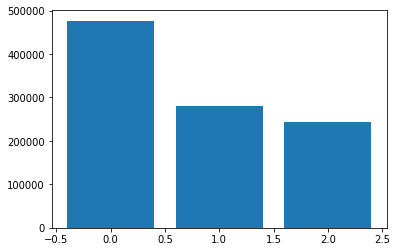

In [137]:
plt.bar(x= counter(_c).keys(), height=counter(_c).values())